In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
from Corrfunc.theory.xi import xi

tutorial at https://bdiemer.bitbucket.io/colossus/_static/tutorial_cosmology_powerspec.html

#### functions

In [3]:
def get_subsample(data, nx=100):
    """Randomly sample 1/nxth entries of a data set."""
    n = len(data)//nx
    print(f"drawing {n} random particles...")
    idx = np.random.choice(len(data), size=n, replace=False)  # get random indices
    return data[idx]

#### parameters for both Colossus and Illustris

In [4]:
# redshift
redshift = 0.0
# separation values
rmin = 0.1
rmax = 25.
nbins = 20
# log bins
rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)
# center of each bin (does this work like this in log?)
ravg = [(rbins[i+1]+rbins[i])/2 for i in range(nbins)]

### Colossus 2pcf

In [5]:
# set cosmology: same as used by Illustris, Planck 2015
cosmo_model = 'planck15'
cosmo = cosmology.setCosmology(cosmo_model, persistence='r')  # persistence='r' sets this to read-only

** We assume that the linear over- and underdensity field is given by a Gaussian random field which is unambiguously described by its power spectrum $P(k)$.

In [6]:
# matter power spectrum
k = np.logspace(-5.0, 2.0, 500)
Pk = cosmo.matterPowerSpectrum(k)  # defaults to the approximation of Eisenstein & Hu 1998

Text(0.5, 1.0, 'Matter power spectrum (planck15 cosmology)')

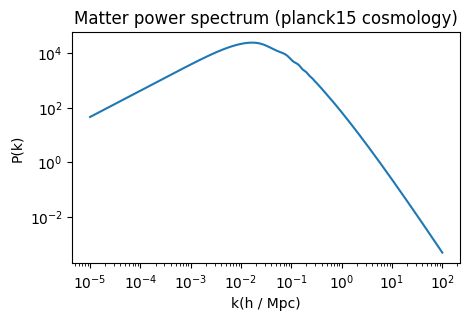

In [7]:
plt.figure(figsize=(5,3))
plt.loglog()
plt.xlabel('k(h / Mpc)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-')
plt.title(f'Matter power spectrum ({cosmo_model} cosmology)')

In [8]:
# derivative to see BAO wiggles more clearly
Pk_deriv = cosmo.matterPowerSpectrum(k, derivative=True)

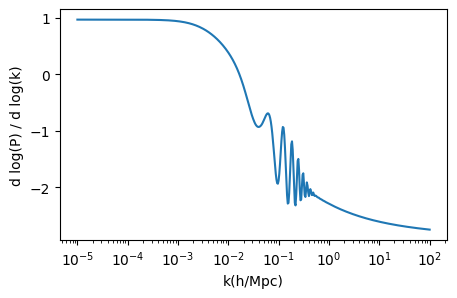

In [9]:
plt.figure(figsize=(5,3))
plt.xscale('log')
plt.xlabel('k(h/Mpc)')
plt.ylabel('d log(P) / d log(k)')
plt.plot(k, Pk_deriv, '-')

#### 2-pt. matter-matter correlation function

integral over the power spectrum:

In [10]:
xi_col = cosmo.correlationFunction(ravg, z=redshift)

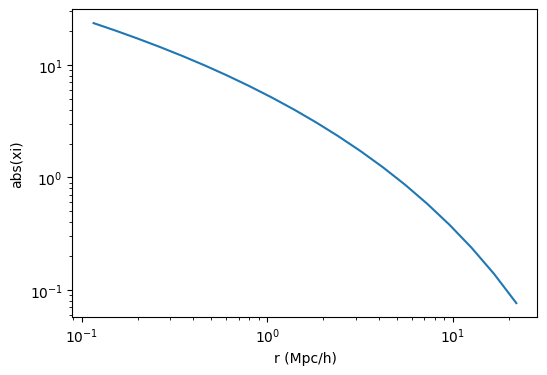

In [11]:
plt.figure(figsize=(6,4))
plt.loglog()
plt.xlabel('r (Mpc/h)')
plt.ylabel('abs(xi)')
plt.plot(ravg, xi_col, '-')

### Illustris 2pcf

In [12]:
# load dark matter positions
basepath = '/scratch/08811/aew492/TNG100-3/output'
dm_pos = il.snapshot.loadSubset(basepath, 99, 'dm', ['Coordinates'])  # snapshot 99 corresponds to z=0.0
# convert from kpc -> Mpc
dm_pos /= 1000

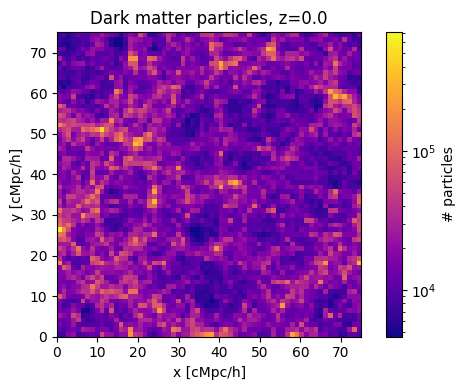

In [14]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,75])
ax.set_ylim([0,75])
ticks = np.linspace(0, 70, 8)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title(f'Dark matter particles, z={redshift}')
fig.tight_layout()

In [15]:
# subsample 1/10th for quicker computation
dm_subsample = get_subsample(dm_pos, nx=10)

drawing 9419637 random particles...


In [16]:
# parameters for Corrfunc
x, y, z = dm_subsample.T
boxsize = float(round(max(x)))
print(boxsize)
nthreads = 12

75.0


In [17]:
# compute 3D 2pcf
xi_il = xi(boxsize, nthreads, rbins, x, y, z)

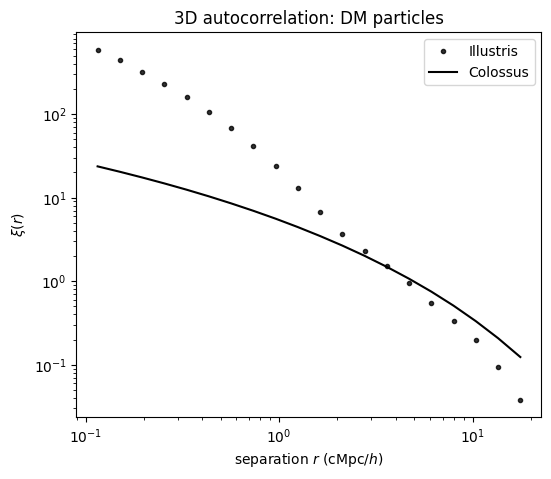

In [20]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(ravg, xi_il['xi'], color='k', marker='.', ls='None', alpha=0.8, label='Illustris')
ax.plot(ravg, xi_col, color='k', label='Colossus')

# ax.axhline(0, lw=0.5, color='k', alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((1e-3,1e2))
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: DM particles')
ax.legend()